# Car Price prediction

## Прогнозирование стоимости автомобиля по характеристикам

## В нашем решении мы делаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#text preproccessing
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
import string
from wordcloud import WordCloud, STOPWORDS

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [15]:
# посмотрим на пропуски и типы данных:
def param_data(data): 
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              }, 
             index = data.loc[0].index)
    return param

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'Train  {train.shape}', f' Test  {test.shape}'],  
          sort=False)

Train  (6682, 22)                Test  (1671, 21)  \
                                dtypes nunique  isna            dtypes   
bodyType                        object      17     0            object   
brand                           object       3     0            object   
color                           object      16     0            object   
description                     object    6147     0            object   
engineDisplacement              object      48     0            object   
enginePower                     object     146     0            object   
fuelType                        object       4     0            object   
mileage                          int64    2900     0             int64   
modelDate                        int64      41     0             int64   
model_info                      object     118     0            object   
name                            object     900     0            object   
numberOfDoors                    int64       4     0             int64   
price                          float64    1628     0               NaN   
productionDate                   int64      38     0             int64   
sell_id                          int64    6682     0             int64   
vehicleConfiguration            object     288     0            object   
vehicleTransmission             object       4     0            object   
Владельцы                       object       3     1            object   
Владение                        object     173  4326            object   
ПТС                             object       2     0            object   
Привод                          object       3     0            object   
Руль                            object       2     0            object   

                                      
                     nunique    isna  
bodyType                14.0     0.0  
brand                    3.0     0.0  
color                   15.0     0.0  
description           1540.0     0.0  
engineDisplacement      43.0     0.0  
enginePower            120.0     0.0  
fuelType                 4.0     0.0  
mileage                935.0     0.0  
modelDate               37.0     0.0  
model_info             101.0     0.0  
name                   536.0     0.0  
numberOfDoors            4.0     0.0  
price                    NaN     NaN  
productionDate          35.0     0.0  
sell_id               1671.0     0.0  
vehicleConfiguration   205.0     0.0  
vehicleTransmission      4.0     0.0  
Владельцы                3.0     0.0  
Владение               131.0  1092.0  
ПТС                      2.0     0.0  
Привод                   3.0     0.0  
Руль                     1.0     0.0

Статистика показывает, что поля 'Владельцы' и 'Владение' содержат пропуски. Обработаем их далее, сейчас же посмотрим, как выглядят распределения числовых признаков:

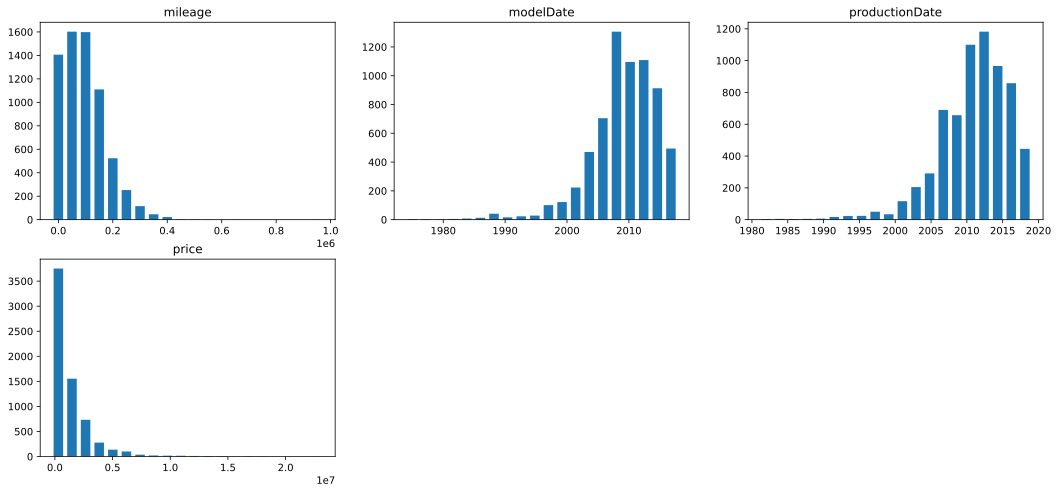

In [21]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna(),
    'price': train['price'].dropna()
})

* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

Проведем первичный анализ целевой переменной:

count        6,682.00
mean     1,899,868.12
std      1,914,153.12
min        301,301.00
25%        800,000.00
50%      1,300,000.00
75%      2,299,283.25
max     23,900,000.00
Name: price, dtype: float64

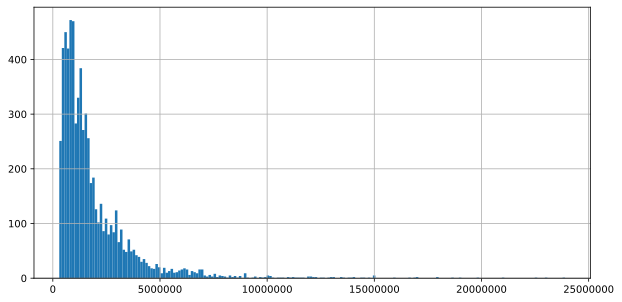

In [22]:
pd.options.display.float_format = '{:,.2f}'.format
rcParams['figure.figsize'] = 10, 5
train.price.hist(bins=200).ticklabel_format(style='plain')
train.price.describe()

Как видно из статистик и графика, 75% цен распределены между 800к и 2,3М (медиана 1.9М, 25-й перцентиль 800к и 75-й — 2.3М). Данные несбалансированы, присутствуют выбросы (например, максимальное значение - почти 25М). Самый простой способ отфильтровать выбросы — воспользоваться формулой интерквартильного расстояния (межквартильного размаха). Выбросом считаются такие значения, которые лежат вне рамок

percentile(25) -1.5IQR : percentile(75)+1.5IQR, где IQR = percentile(75) - percentile(25).

25-й перцентиль: 800000.0, 75-й перцентиль: 2299283.25, IQR: 1499283.25,  Границы выбросов: [-1448924.875, 4548208.125].


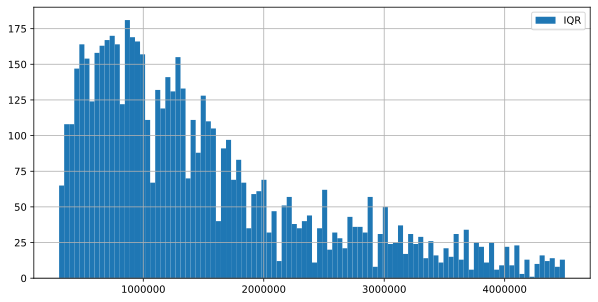

In [23]:
median = train.price.median()
IQR = train.price.quantile(0.75) - train.price.quantile(0.25)
perc25 = train.price.quantile(0.25)
perc75 = train.price.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

rcParams['figure.figsize'] = 10, 5

train.price.loc[train.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 100, label = 'IQR').ticklabel_format(style='plain')

plt.legend();

Этот способ позволил нам отобрать экстремально экстремально высокие значения признака, которые в дальнейшем могли бы негативно влиять на обучение модели. Отфильтруем данные:

In [19]:
train = train.loc[train.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

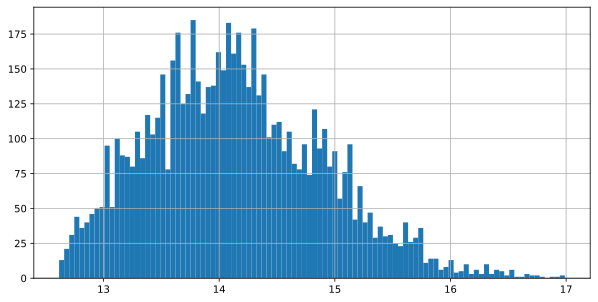

In [24]:
rcParams['figure.figsize'] = 10, 5
np.log1p(train.price).hist(bins=100);

 Применим логарифмирование целевой переменной:

In [21]:
train["price"] = np.log1p(train["price"])

# PreProc Tabular Data

In [22]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6233, 23) (1671, 23) (7904, 23)


In [23]:
#удалим дубликаты, если они есть:
data = data.drop_duplicates()
print(data.shape)

(7904, 23)


Извлечем дополнительные признаки из поля description:

In [24]:
# Сконструируем dummy variables для признака 'description'

DESCRIPTION_PATTERN = {
    "leather"                 : "'кожа' or 'кожаный' and 'салон'", 
    "carter"                  : "'защита' and 'картера'", 
    "ABS"                     : "'антиблокировочная' and 'система'", 
    "airbags"                 : "'подушки' and 'безопасности'", 
    "immob"                   : "'иммобилайзер'", 
    "central_locking"         : "'центральный' and 'замок'", 
    "on_board_computer"       : "'бортовой' and 'компьютер'", 
    "cruise_control"          : "'круиз-контроль' or 'круиз'", 
    "climat_control"          : "'климат-контроль' or 'климат'", 
    "multi_rudder"            : "'мультифункциональный' and 'руль'", 
    "power_steering"          : "( 'гидроусилитель' or 'гидро' or 'усилитель' ) and 'руля'", 
    "light_and_rain_sensors"  : "'датчики' and 'света' and 'дождя'", 
    "сarbon_body_kits"        : "'карбоновые' and 'обвесы'", 
    "rear_diffuser_rkp"       : "'задний' and 'диффузор'", 
    "door_closers"            : "'доводчики' and 'дверей'", 
    "rear_view_camera"        : "( 'камера' or 'видеокамера' ) and 'заднего' and 'вида'", 
    "amg"                     : "'amg'", 
    "bi_xenon_headlights"     : "( 'биксеноновые' or 'биксенон' ) and 'фары'", 
    "car_dealer"              : "'рольф' or 'панавто' or 'дилер' or 'кредит' or 'ликвидация'", 
    "alloy_wheels"            : "'литые' or 'колесные' or 'диски'", 
    "parking_sensors"         : "'парктроник' or 'парктронник'", 
    "dents"                   : "'вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина'", 
    "roof_with_panoramic_view": "'панорамная' and 'крыша'",
    "hatch"                   : "'люк'",
}

def compose_query(pattern):
    query = ''
    for w in pattern.split():
        query += w + (' ' if w in ['or', 'and', '(', ')'] else ' in x ')
    return eval(f'lambda x: {query}')

Queries = {f: compose_query(p) for f, p in DESCRIPTION_PATTERN.items()}

for feature in DESCRIPTION_PATTERN:
    data[feature] = data['description'].apply(
        lambda descr: int(Queries[feature](descr)))

In [25]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name', 'numberOfDoors',
   'vehicleTransmission', 'Владельцы',  'ПТС', 'Привод', 'Руль', 'engineDisplacement']


#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','enginePower','Владение','sell_id','description_len', 'leather', 'carter', 'ABS',
       'airbags', 'immob', 'central_locking', 'on_board_computer',
       'cruise_control', 'climat_control', 'multi_rudder', 'power_steering',
       'light_and_rain_sensors', 'сarbon_body_kits', 'rear_diffuser_rkp',
       'door_closers', 'rear_view_camera', 'amg', 'bi_xenon_headlights',
       'car_dealer', 'alloy_wheels', 'parking_sensors', 'dents',
       'roof_with_panoramic_view', 'hatch']

dummy_features = ['bodyType','color','engineDisplacement','model_info']

In [26]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
       
    
    df_output['bodyType'] = df_output.bodyType.apply(lambda x: x.split()[0])
    
    df_output['engineDisplacement'] = df_output.engineDisplacement.apply(lambda x: x.split()[0] if x!='undefined LTR' else '2.0').astype(float)
    df_output['engineDisplacement'] = df_output.engineDisplacement.apply(lambda x: 'small' if x<2 else 'middle' if 2<=x<3.5 else 'big' )
    
    df_output['enginePower'] = df_output.enginePower.apply(lambda x: x.split()[0]).astype('int')
    
    # Владение - преобразование  в числовой признак
    df_output['Владение'] = df_output['Владение'].apply(lambda x: x.split() if not pd.isna(x) else x)
    df_output['Владение'] = df_output['Владение'].apply(lambda x: x if not isinstance(x, list) else (12*int(x[0]) + int(x[3])) 
                                                      if len(x) > 3 else 12*int(x[0])
                                                      if x[1][0] == 'г' else int(x[0])
                                         )
    df_output['Владение'] = df_output['Владение'].fillna(round(datetime.now().year - df_output['productionDate']) * 12)
    df_output['Владение'] = df_output['Владение'].astype('int32')
    
    df_output['Владельцы'] = df_output['Владельцы'].fillna(3.0)
   
    #Выделим дополнительный признаки из поля name
    df_output['has_steptronic'] = df_output['name'].str.extract(r'(Steptronic)')[0]
    df_output['has_steptronic'] = df_output['has_steptronic'].apply(lambda x: 0 if pd.isna(x) else 1)
    df_output['has_xdrive'] = df_output['name'].str.extract(r'(xDrive)')[0]
    df_output['has_xdrive'] = df_output['has_xdrive'].apply(lambda x: 0 if pd.isna(x) else 1)
    df_output['name'] = df_output['name'].str.split().str[0]
    
    # ################### Feature Engineering ####################################################
    #Создадим признак длина обявления
    df_output['description_len'] = df_output['description'].apply(lambda x: len(x.split()))
    
    #Добавляем признаки на основе временных характеристик
    df_output['modelDate'] = datetime.now().year - df_output['modelDate']
    df_output['productionDate'] = datetime.now().year - df_output['productionDate']
    
    
    cats = list(set(categorical_features) - set(dummy_features))
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in cats:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    labelencoder = LabelEncoder()
    for feature in cats:
        df_output[feature] = labelencoder.fit_transform(df_output[feature])
        
    # Нормализация данных
    scaler = RobustScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    for column in cats:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=dummy_features, dummy_na=False)
   
    #scaler = MinMaxScaler()
    #for column in numerical_features:
        #df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Clean #################################################### 
    # убираем не нужные для модели признаки и признаки которые еще не успели обработать:
    df_output.drop(['description', 'vehicleConfiguration'], axis = 1, inplace=True)  
        
    
    return df_output

In [27]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,brand,enginePower,fuelType,mileage,modelDate,name,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,leather,carter,ABS,airbags,immob,central_locking,on_board_computer,cruise_control,climat_control,multi_rudder,power_steering,light_and_rain_sensors,сarbon_body_kits,rear_diffuser_rkp,door_closers,rear_view_camera,amg,bi_xenon_headlights,car_dealer,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,hatch,has_steptronic,has_xdrive,description_len,bodyType_внедорожник,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,...,model_info_Q8,model_info_R8,model_info_RS3,model_info_RS4,model_info_RS5,model_info_RS6,model_info_RS7,model_info_RSQ3,model_info_R_KLASSE,model_info_S3,model_info_S4,model_info_S5,model_info_S6,model_info_S7,model_info_S8,model_info_SLC_KLASSE,model_info_SLC_KLASSE_AMG,model_info_SLK_KLASSE,model_info_SLK_KLASSE_AMG,model_info_SLR_KLASSE,model_info_SLS_AMG,model_info_SL_KLASSE,model_info_SL_KLASSE_AMG,model_info_SQ5,model_info_S_CLASS_MAYBACH,model_info_S_KLASSE,model_info_S_KLASSE_AMG,model_info_TT,model_info_TTS,model_info_VIANO,model_info_VITO,model_info_V_KLASSE,model_info_W123,model_info_W124,model_info_W201,model_info_X1,model_info_X2,model_info_X3,model_info_X4,model_info_X4_M,model_info_X5,model_info_X5_M,model_info_X6,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4
3467,0.00,1.91,0.00,0.43,0.43,1.39,0.00,0.17,0.20,0.00,0.50,0.50,0.00,0.00,0.00,1,13.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,-0.46,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
465,0.00,-0.42,0.00,-0.12,-0.29,0.71,0.00,-0.33,0.20,0.00,0.00,0.00,0.00,-1.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0,0,-0.23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
453,-1.00,-0.64,0.00,1.30,1.00,-0.89,0.00,0.83,-0.27,1.00,0.00,0.43,0.00,-0.50,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4912,0.00,0.35,0.00,0.09,0.29,0.84,0.00,0.17,0.20,0.00,0.50,0.50,0.00,-1.00,0.00,1,13.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.46,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4568,1.00,0.85,0.00,0.05,0.14,0.26,0.00,0.17,-0.70,0.00,0.00,-0.68,0.00,-1.00,0.00,1,14.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1701,0.00,0.26,0.00,-0.35,-0.71,0.89,0.00,-0.83,-0.14,0.00,-0.50,-0.50,0.00,0.00,0.00,1,14.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0,1,1.14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6067,0.00,-1.14,0.00,0.61,0.57,-0.75,1.00,0.50,0.06,0.00,0.00,0.83,0.00,-1.00,0.00,1,12.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1.34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5555,0.00,1.91,0.00,0.95,0.14,0.70,1.00,0.33,0.01,0.00,0.50,0.67,0.00,0.00,0.00,1,13.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

In [28]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7904 entries, 0 to 7903
Columns: 195 entries, brand to model_info_Z4
dtypes: float64(41), int64(3), uint8(151)
memory usage: 3.9 MB


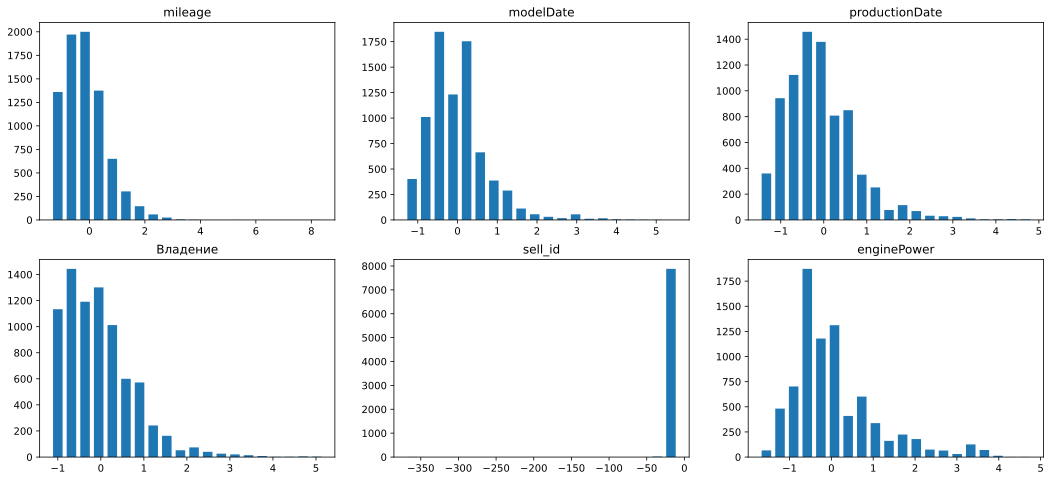

In [29]:
#посмотрим, как сейчас выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': df_preproc['mileage'].dropna(),
    'modelDate': df_preproc['modelDate'].dropna(),
    'productionDate': df_preproc['productionDate'].dropna(),
    'Владение': df_preproc['Владение'].dropna(),
    'sell_id': df_preproc['sell_id'].dropna(),
    'enginePower': df_preproc['enginePower'].dropna()
    
})

## Split data

In [102]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 194 entries, brand to model_info_Z4
dtypes: float64(41), int64(2), uint8(151)
memory usage: 820.8 KB


# Model 2: CatBoostRegressor

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [33]:
model = CatBoostRegressor(iterations = 7000,
                          #depth=6,
                          #learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          #l2_leaf_reg=2,
                          #bootstrap_type = 'Bayesian',
                          #one_hot_max_size = 6,
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.018787
0:	learn: 0.0370801	test: 0.0371104	best: 0.0371104 (0)	total: 56.3ms	remaining: 6m 34s
500:	learn: 0.0086480	test: 0.0094704	best: 0.0094704 (500)	total: 2.47s	remaining: 32s
1000:	learn: 0.0075776	test: 0.0087630	best: 0.0087630 (1000)	total: 4.8s	remaining: 28.8s
1500:	learn: 0.0069296	test: 0.0083902	best: 0.0083898 (1498)	total: 7.2s	remaining: 26.4s
2000:	learn: 0.0064716	test: 0.0082001	best: 0.0082001 (2000)	total: 10.3s	remaining: 25.6s
2500:	learn: 0.0060795	test: 0.0080976	best: 0.0080976 (2500)	total: 12.9s	remaining: 23.2s
3000:	learn: 0.0057591	test: 0.0080365	best: 0.0080365 (3000)	total: 15.7s	remaining: 21s
3500:	learn: 0.0054504	test: 0.0079852	best: 0.0079851 (3497)	total: 18.1s	remaining: 18.1s
4000:	learn: 0.0051788	test: 0.0079548	best: 0.0079548 (4000)	total: 21.2s	remaining: 15.9s
4500:	learn: 0.0049469	test: 0.0079366	best: 0.0079345 (4457)	total: 23.6s	remaining: 13.1s
5000:	learn: 0.0047198	test: 0.0079103	best: 0.0079103 (5000)	

In [34]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test),np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.04%


In [35]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

После подбора числа итераций даже на дефолтном lr Catboost дает неплохой результат в 11.04%. Ниже попробую его слегка улучшить, введя кросс-валидацию:

In [36]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(loss_function = 'MAE',
                             eval_metric = 'MAPE',
                             #learning_rate=0.005,
                             iterations=10000,
                             #l2_leaf_reg=2,
                             #depth=6,
                             #bootstrap_type = 'Bayesian', # Bayesian Bernoulli
    #                          subsample = 0.8,
                             #one_hot_max_size = 5,
                             random_seed=42,
                             #od_type='Iter',
                             od_wait=500)

    model.fit(X_train, y_train,
                       
              eval_set=(X_test, y_test),
              verbose_eval=500,
              use_best_model=True,
              plot=False)
    
    return(model)


submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=7, shuffle=True, random_state=42).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=7,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(np.exp(y_test), np.exp(test_predict))
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(np.exp(y_test), np.exp(test_predict)):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = np.exp(model.predict(X_sub))
    #model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls)*100:0.3f}%')
print(f'Std Score: {np.std(score_ls)*100:0.4f}%')
print(f'Max Score: {np.max(score_ls)*100:0.3f}%')
print(f'Min Score: {np.min(score_ls)*100:0.3f}%')

0:	learn: 0.0367210	test: 0.0368808	best: 0.0368808 (0)	total: 6.71ms	remaining: 1m 7s
500:	learn: 0.0075558	test: 0.0087019	best: 0.0087019 (500)	total: 4.01s	remaining: 1m 16s
1000:	learn: 0.0064012	test: 0.0083004	best: 0.0083004 (1000)	total: 6.63s	remaining: 59.6s
1500:	learn: 0.0057300	test: 0.0081757	best: 0.0081755 (1499)	total: 9.23s	remaining: 52.3s
2000:	learn: 0.0052595	test: 0.0081385	best: 0.0081360 (1799)	total: 12.5s	remaining: 50.1s
2500:	learn: 0.0049347	test: 0.0081204	best: 0.0081204 (2500)	total: 15.6s	remaining: 46.8s
3000:	learn: 0.0046702	test: 0.0080927	best: 0.0080906 (2929)	total: 18.7s	remaining: 43.7s
3500:	learn: 0.0044603	test: 0.0080811	best: 0.0080801 (3453)	total: 21.5s	remaining: 39.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.00808014738
bestIteration = 3453

Shrink model to first 3454 iterations.
1 Fold Test MAPE: 0.112
0:	learn: 0.0367350	test: 0.0368699	best: 0.0368699 (0)	total: 5.99ms	remaining: 59.9s
500:	learn: 0.007

Обучение на 7 фолдах дало прирост прирост в mape c 11.04 до 10.785%.

### Submission

In [37]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7
0,"645,728.62","621,325.99","629,189.36","665,883.83","581,366.65","550,273.25","618,792.71"
1,"2,401,261.84","2,433,020.03","2,603,241.40","2,548,545.69","2,545,676.31","2,590,150.15","2,660,998.67"
2,"685,644.80","664,030.97","664,466.07","656,340.74","652,699.25","664,917.80","663,916.82"
3,"461,651.62","463,695.87","465,809.21","467,568.84","471,258.93","464,144.70","463,457.27"
4,"2,769,088.57","2,740,056.35","2,747,647.65","2,791,470.15","2,796,303.01","2,785,150.72","2,755,040.64"
5,"2,951,302.82","2,992,754.41","2,963,566.61","2,975,445.91","2,912,706.50","2,987,225.73","3,005,861.79"
6,"1,517,557.92","1,570,177.94","1,537,464.48","1,533,946.04","1,473,645.11","1,517,825.97","1,544,736.93"
7,"1,231,282.89","1,147,114.62","1,351,682.87","1,143,641.29","1,107,322.20","1,150,665.43","1,131,372.19"
8,"1,101,397.97","1,041,451.64","1,032,326.64","1,040,731.43","1,073,238.50","1,084,650.85","1,060,551.43"
9,"512,595.52","509,883.11","494,792.41","478,179.97","508,887.68","500,888.43","496,817.99"


In [38]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv('blend_catboost.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1099427284,"616,080.06"
1,1096405886,"2,540,413.44"
2,1100195294,"664,573.78"
3,1099827282,"465,369.49"
4,1100076198,"2,769,251.01"
5,1090159352,"2,969,837.68"
6,1098987386,"1,527,907.77"
7,1098639040,"1,180,440.21"
8,1099933039,"1,062,049.78"
9,1099565572,"500,292.16"


# Model 3: Tabular NN

Цель данного блока - понять, какой результат может быть получен на табличных данных, если вместо классического ML-алгоритма применить нейронную сеть. Построим обычную сеть:

In [39]:
X_train.head(5)

,brand,enginePower,fuelType,mileage,modelDate,name,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,leather,carter,ABS,airbags,immob,central_locking,on_board_computer,cruise_control,climat_control,multi_rudder,power_steering,light_and_rain_sensors,сarbon_body_kits,rear_diffuser_rkp,door_closers,rear_view_camera,amg,bi_xenon_headlights,car_dealer,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,hatch,has_steptronic,has_xdrive,description_len,bodyType_внедорожник,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_минивэн,...,model_info_Q8,model_info_R8,model_info_RS3,model_info_RS4,model_info_RS5,model_info_RS6,model_info_RS7,model_info_RSQ3,model_info_R_KLASSE,model_info_S3,model_info_S4,model_info_S5,model_info_S6,model_info_S7,model_info_S8,model_info_SLC_KLASSE,model_info_SLC_KLASSE_AMG,model_info_SLK_KLASSE,model_info_SLK_KLASSE_AMG,model_info_SLR_KLASSE,model_info_SLS_AMG,model_info_SL_KLASSE,model_info_SL_KLASSE_AMG,model_info_SQ5,model_info_S_CLASS_MAYBACH,model_info_S_KLASSE,model_info_S_KLASSE_AMG,model_info_TT,model_info_TTS,model_info_VIANO,model_info_VITO,model_info_V_KLASSE,model_info_W123,model_info_W124,model_info_W201,model_info_X1,model_info_X2,model_info_X3,model_info_X4,model_info_X4_M,model_info_X5,model_info_X5_M,model_info_X6,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4
1671,0.00,0.50,0.00,1.27,0.57,0.91,0.00,0.83,0.20,0.00,0.50,1.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1672,-1.00,-0.21,0.00,0.66,0.00,-0.42,0.00,0.17,-1.21,1.00,0.00,0.42,0.00,-0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1673,1.00,0.85,0.00,0.07,0.29,0.26,0.00,-0.17,0.27,0.00,0.50,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0,0,0.69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1674,-1.00,-0.46,0.00,0.34,0.00,-0.54,0.00,0.17,0.17,1.00,0.50,-0.21,0.00,-0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1676,1.00,-0.42,0.00,1.11,0.71,-0.40,0.00,0.83,-16.77,0.00,0.50,0.12,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,-0.18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Simple Dense NN

In [190]:
model = Sequential()
model.add(L.Dense(130, input_dim=X_train.shape[1], activation="sigmoid")) #активация sigmoid вместо relu
model.add(L.Dropout(0.3)) #Подобраны параметры Dropout
#model.add(L.BatchNormalization()) #добавила нормализацию - ухудшило результат
model.add(L.Dense(86, activation="sigmoid")) #активация sigmoid вместо relu
#model.add(L.Dropout(0.3)) #ухудшило результат
#model.add(L.BatchNormalization()) #добавила нормализацию - ухудшило результат
model.add(L.Dense(1, activation="linear"))

In [191]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 130)               25220     
_________________________________________________________________
dropout_28 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 86)                11266     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 87        
Total params: 36,573
Trainable params: 36,573
Non-trainable params: 0
_________________________________________________________________


In [192]:
# Compile model
#Добавляю условия на lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [193]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [194]:
#Обучаем модель
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

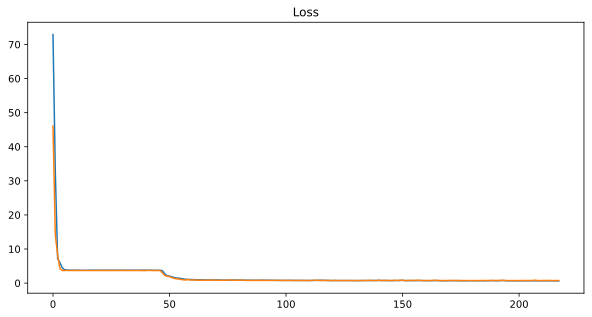

In [195]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [196]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [197]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 10.84%


Простая NN дает 10.84% mape на тесте для логарифмированной целевой переменной. Подбор количества нейронов, параметров для регуляризации Dropout и активации позволили улучшить первоначальную метрику в 14.24%.

In [181]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_nn1[:,0])
sample_submission.to_csv('nn1_submission1.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,"701,780.00"
1,1096405886,"2,532,679.00"
2,1100195294,"711,587.12"
3,1099827282,"486,068.91"
4,1100076198,"2,694,513.75"


In [182]:
#Делаю бленд catboost и Dense NN - показал лучший результат на Kaggle 11.76%
sub_predict_nn1=np.exp(sub_predict_nn1)
blend_sub_predict=(submissions['blend'] + sub_predict_nn1[:,0])/2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_catboost_nn1_submission1.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [65]:
#Посмотрим внимательнее на поле Description
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
7899    Продаётся любимый автомобиль! За годы эксплуат...
7900    Куплена у официального дилера в 2017 г. \n\nТр...
7901    Торг на месте. Все работает. Сборка немецкая. ...
7902    Автомобиль в отличном состоянии.\n3-из Авто в ...
7903    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 7904, dtype: object

Подготовка текста:

In [66]:
#сформируем словарь стоп-слов для очистки признака
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
mystem = Mystem() 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [67]:
#Определим функцию для очисти полей с описанием от знаков пунктуации и цифр и лемматизацией

def text_prep(x):
    x = mystem.lemmatize(str(x).lower())
    spec_chars = string.punctuation + '[\xa0«»\t—…•–0123456789☛✅·☑️⭐🔥❤●▼!"#$%&\'()*+,-./:;?@[\\]^_`{|}~]∙' #убираю доп.символы
    x = "".join([ch for ch in x if ch not in string.digits]) #убираю числа
    x = ' '.join(x.split()) #убираю символы переноса строки
    x = ' '.join([word for word in x.split() if word not in (stopwords.words('russian'))]) #очищаю строки от стоп-слов
    x = "".join([ch for ch in x if ch not in spec_chars])
    x = re.sub(r'[a-z]', '', x) #убираю английские буквы из текста
    
    return x


In [68]:
print(f"Пример текста до обработки:\n{data['description'].iloc[0]}\n")

data['description']=data['description'].apply(text_prep)

print(f"Пример текста после обработки:\n{data['description'].iloc[0]}")

Пример текста до обработки:
Всем привет!

Продам эксклюзивный проект 124 универсал 300TE-24 SportLine

Модель 124.091 300 TE-24
Двигатель 104.980
Трансмиссия 722.359
Цвет кузова 040 (черный)
Отделка салона 271 (Кожа черная / "антрацит")

Опции:
211 Автоматическая блокировка дифференциала (ASD)
240 Индикатор внешней температуры
244 Спортивные сиденья спереди
281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП
291 Подушка безопасности для водителя и переднего пассажира
300 Дополнительный бардачок в вещевом отсеке спереди
412 Люк с электроприводом и устройством подъёма
420 Автоматическая коробка передач, напольное исполнение
440 Темпомат (круиз-контроль)
538 Автоматическая антенна
541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)
570 Складной подлокотник спереди
586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей
598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)
650 Спо

In [69]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

# TOKENIZER

In [70]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [71]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.59 s, sys: 7.25 ms, total: 1.59 s
Wall time: 1.66 s


In [72]:
#Визуально проверяем получившиеся токены
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'весь': 4,
 'салон': 5,
 'задний': 6,
 'состояние': 7,
 'год': 8,
 'сидение': 9,
 'машина': 10,
 'передний': 11,
 'комплект': 12,
 'диск': 13,
 'дилер': 14,
 'новый': 15,
 'кредит': 16,
 'официальный': 17,
 'ваш': 18,
 'фара': 19,
 'авто': 20,
 'гарантия': 21,
 'руль': 22,
 'колесо': 23,
 'комплектация': 24,
 'обмен': 25,
 'безопасность': 26,
 'птс': 27,
 'проверка': 28,
 'покупка': 29,
 'продажа': 30,
 'полный': 31,
 'отличный': 32,
 'зеркало': 33,
 'резина': 34,
 'владелец': 35,
 'условие': 36,
 'датчик': 37,
 'продавать': 38,
 'двигатель': 39,
 'пакет': 40,
 'хороший': 41,
 'шина': 42,
 'ключ': 43,
 'водитель': 44,
 'любой': 45,
 'технический': 46,
 'кузов': 47,
 'обслуживание': 48,
 'проходить': 49,
 'пассажир': 50,
 'км': 51,
 'подушка': 52,
 'масло': 53,
 'торг': 54,
 'замена': 55,
 'оригинал': 56,
 'юридический': 57,
 'обогрев': 58,
 'подогрев': 59,
 'оригинальный': 60,
 'купить': 61,
 'стекло': 62,
 'наш': 63,
 'дтп': 64,
 'зимний

In [73]:
print('Found %s unique tokens. ' % len(tokenize.word_index))

Found 18633 unique tokens. 


In [104]:
%%time
#Преобразуем получившиеся последовательности в 2d массив
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5343, 256) (890, 256) (1671, 256)
CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 1.91 s


In [105]:
# вот так теперь выглядит наш текст
print(text_train.iloc[10])
print(text_train_sequences[10])

продавать ухоженный авто отличный состояние ухаживать относиться бережно масло есть коробка пинать подвеска идеал замена масло    км недавно замена масло коробка весь мелочь тип ролик ремень меняться фильтр тд сзади никто ездить стоять максимальный музыка   руб допы опция авто обслуживаться трилучник накладный работа быть ключ  новый зимний резина комплект последний время машина передаигаться редко тк второе авто проверка сервис приветствоваться торг капот умеренный
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0

### RNN NLP

Были проведены экперименты по подбору числа нейронов в слоях и подобраны параметры Dropout. Также пробовала добавлять BatchNormalization, но она ухудшала результат.

In [221]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(669, return_sequences=True))
model_nlp.add(L.Dropout(0.2))
#model_nlp.add(L.BatchNormalization()) 
model_nlp.add(L.LSTM(446,)) 
#model_nlp.add(L.Dropout(0.3))
#model_nlp.add(L.BatchNormalization()) 
model_nlp.add(L.Dense(64, activation="sigmoid"))#активация sigmoid вместо relu
model_nlp.add(L.Dropout(0.25))

### MLP

In [222]:
model_mlp = Sequential()
model_mlp.add(L.Dense(130, input_dim=X_train.shape[1], activation="sigmoid")) #активация sigmoid вместо relu
model_mlp.add(L.Dropout(0.3)) #Подобраны параметры Dropout
#model_mlp.add(L.BatchNormalization()) #добавила нормализацию
model_mlp.add(L.Dense(86, activation="sigmoid")) #активация sigmoid вместо relu
#model_mlp.add(L.Dropout(0.55)) #Подобраны параметры Dropout
#model_mlp.add(L.BatchNormalization()) #добавила нормализацию

### Multiple Inputs NN

In [223]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [224]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 256, 256)     4770304     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 256, 669)     2477976     embedding_9[0][0]                
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 256, 669)     0           lstm_19[0][0]                    
______________________________________________________________________________________

### Fit

In [225]:
#Добавляю условия на lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [226]:
#формирую чекпойнты
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [227]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 9s 797ms/step - loss: 28.2246 - MAPE: 28.2246 - val_loss: 8.9847 - val_MAPE: 8.9847
Epoch 2/500
11/11 [==============================] - 8s 693ms/step - loss: 7.4622 - MAPE: 7.4622 - val_loss: 3.4751 - val_MAPE: 3.4751
Epoch 3/500
11/11 [==============================] - 8s 690ms/step - loss: 5.2290 - MAPE: 5.2290 - val_loss: 3.3562 - val_MAPE: 3.3562
Epoch 4/500
11/11 [==============================] - 8s 696ms/step - loss: 4.1089 - MAPE: 4.1089 - val_loss: 1.5773 - val_MAPE: 1.5773
Epoch 5/500
11/11 [==============================] - 8s 692ms/step - loss: 3.4318 - MAPE: 3.4318 - val_loss: 1.4328 - val_MAPE: 1.4328
Epoch 6/500
11/11 [==============================] - 8s 690ms/step - loss: 2.7416 - MAPE: 2.7416 - val_loss: 1.8833 - val_MAPE: 1.8833
Epoch 7/500
11/11 [==============================] - 8s 696ms/step - loss: 2.1528 - MAPE: 2.1528 - val_loss: 1.6349 - val_MAPE: 1.6349
Epoch 8/500
11/11 [==============================] - 

11/11 [==============================] - 8s 691ms/step - loss: 1.0843 - MAPE: 1.0843 - val_loss: 0.9758 - val_MAPE: 0.9758
Epoch 122/500
11/11 [==============================] - 8s 699ms/step - loss: 0.9595 - MAPE: 0.9595 - val_loss: 0.9248 - val_MAPE: 0.9248
Epoch 123/500
11/11 [==============================] - 8s 690ms/step - loss: 1.0650 - MAPE: 1.0650 - val_loss: 1.5748 - val_MAPE: 1.5748
Epoch 124/500
11/11 [==============================] - 8s 690ms/step - loss: 0.9973 - MAPE: 0.9973 - val_loss: 1.2211 - val_MAPE: 1.2211
Epoch 125/500
11/11 [==============================] - 8s 693ms/step - loss: 1.0407 - MAPE: 1.0407 - val_loss: 1.6420 - val_MAPE: 1.6420
Epoch 126/500
11/11 [==============================] - 8s 685ms/step - loss: 1.2012 - MAPE: 1.2012 - val_loss: 1.5963 - val_MAPE: 1.5963
Epoch 127/500
11/11 [==============================] - 8s 688ms/step - loss: 1.1857 - MAPE: 1.1857 - val_loss: 0.9190 - val_MAPE: 0.9190
Epoch 128/500
11/11 [==============================] - 

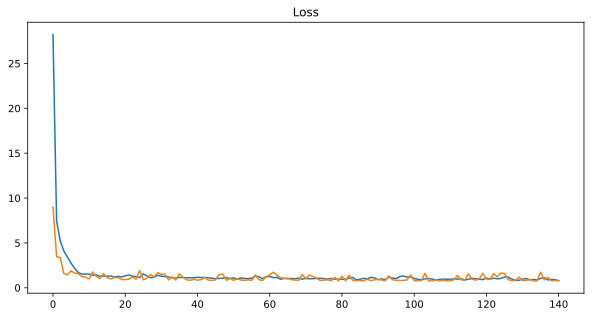

In [229]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [231]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [230]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn2[:,0])))*100:0.2f}%")

TEST mape: 10.93%


Значение метрики увеличено с 14.23% до 10.93% за счет смены функции активации и подбора количества нейронов, а также за счет предобработки табличных данных и лемматизации текста в описании.

In [232]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_nn2[:,0])
sample_submission.to_csv('nn2_submission3.csv', index=False)

In [233]:
sample_submission.head()

,sell_id,price
0,1099427284,"636,194.94"
1,1096405886,"2,807,460.00"
2,1100195294,"736,439.62"
3,1099827282,"489,675.25"
4,1100076198,"2,900,647.50"


# Model 5: Добавляем картинки

### Data

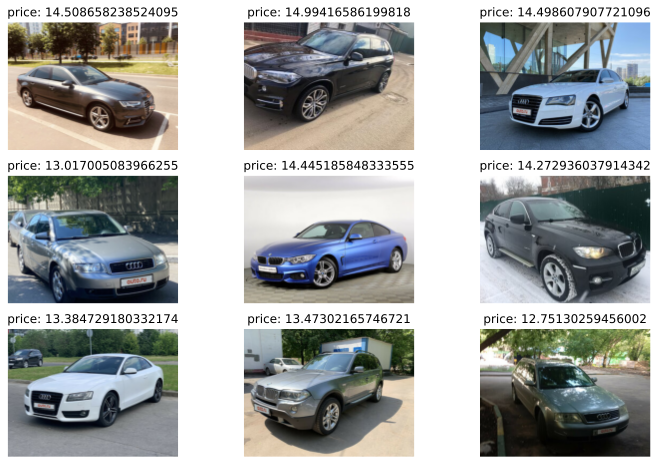

In [234]:
# убедимся, что цены и фото подгрузились верно (цены отображаются в прологарифмированном виде)
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [235]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5343, 240, 320, 3) dtype uint8
images shape (890, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

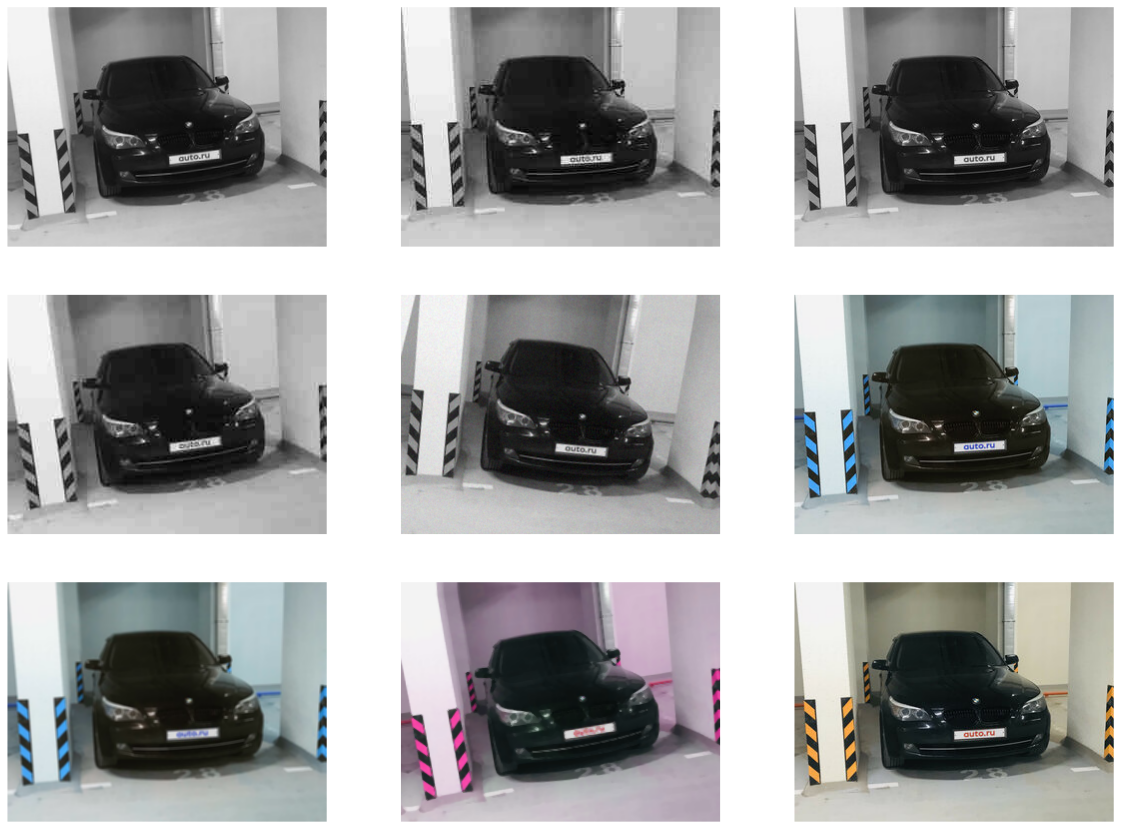

In [236]:
import albumentations as alb
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

augmentation = alb.Compose([
    alb.OneOf([                                  # выбираем вариант разворота изображения
        # alb.HorizontalFlip(),
        # alb.Transpose(),
        alb.Rotate(limit=10),
        # alb.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, approximate=False)
    ], p = 0.6),
    alb.OneOf([
        # alb.ToSepia(),
        alb.ToGray(),              
    ], p = 0.3),
    alb.OneOf([
        alb.ChannelShuffle(),
        # alb.ChannelDropout()        
    ], p=0.3),
    alb.OneOf([                                 # выбираем один из вариантов размытия изображения
        alb.MotionBlur(blur_limit=3),
        alb.MedianBlur(blur_limit=3),
        alb.Blur(blur_limit=3)        
    ], p = 0.3),
    alb.OneOf([
        alb.OpticalDistortion(p=0.3),
        alb.GridDistortion(p=0.1),
        alb.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    alb.OneOf([
        alb.IAAAdditiveGaussianNoise(),         # выбираем один из видов шумов
        alb.GaussNoise(),
        # alb.ISONoise()
    ], p = 0.3),
    alb.JpegCompression(quality_lower=12, quality_upper=100, p=0.3),   # компрессия
    alb.RandomBrightnessContrast(0.2, 0.2, p=0.3)
])

plt.figure(figsize = (20,15))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [237]:
#Функция для применения аугментации
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [130]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [131]:
#Подготавливаю комбинированные датасеты для обучения multi-input сети
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

#готолю датасеты для обучения
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_test, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

# MODEL

In [132]:
#Подбираем количество нейронов для обучения Tabular NN и NLP NN
def number_of_nodes(layers, input_shape, output_shape):

  # #############################################################
  # layers - количествой слоев в нейронной сети
  # input_shape - количество признаков нейронной сети на входе
  # output_shape - необходимое количество нейронов выходного слоя
  # #############################################################

  for num_of_layers in range(layers):
    num_of_tabular_neurons = int(2/3 * (input_shape * output_shape))
    input_shape = num_of_tabular_neurons
    print(f'Количесто нейронов {num_of_layers+1} слоя: {num_of_tabular_neurons}')

In [238]:
print('Tabular NN:')
number_of_nodes(2, 195, 1)
print('')
print('NLP NN:')
number_of_nodes(3, 256, 1)
print('')
print('Concationation:')
number_of_nodes(2, 451, 1)

Tabular NN:
Количесто нейронов 1 слоя: 130
Количесто нейронов 2 слоя: 86

NLP NN:
Количесто нейронов 1 слоя: 170
Количесто нейронов 2 слоя: 113
Количесто нейронов 3 слоя: 75

Concationation:
Количесто нейронов 1 слоя: 300
Количесто нейронов 2 слоя: 200


### Строим сверточную сеть для анализа изображений без "головы"

In [239]:
#нормализация включена в состав модели EfficientNetB4, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

71688192/71686520 [==============================] - 3s 0us/step


СОБИРАЕМ ВСЕ 3 МОДЕЛИ ВМЕСТЕ:

In [240]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(130, activation = 'sigmoid'),
    L.Dropout(0.3),
    #L.BatchNormalization(),
    L.Dense(86, activation = 'sigmoid'),
    #L.Dropout(0.55),
    #L.BatchNormalization(),
    ])

In [241]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(669, return_sequences=True),
    L.Dropout(0.2), #подобран параметр
    #L.BatchNormalization(), #добавлено
    L.LSTM(446),
    #L.Dropout(0.3), 
    #L.BatchNormalization(),#добавлено
    L.Dense(64, activation="sigmoid"),#активация sigmoid вместо relu
    L.Dropout(0.25),
    ])

In [243]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(300, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________

In [244]:
#добавляю политику на LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.005)

#компилирую модель
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [245]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [246]:
history = model.fit(train_dataset.batch(35),
                    epochs=500,
                    validation_data = test_dataset.batch(35),
                    callbacks=callbacks_list
                   )

Epoch 1/500
153/153 [==============================] - 166s 1s/step - loss: 7.8222 - MAPE: 7.8222 - val_loss: 8.5477 - val_MAPE: 8.5477
Epoch 2/500
153/153 [==============================] - 160s 1s/step - loss: 1.9537 - MAPE: 1.9537 - val_loss: 1.1700 - val_MAPE: 1.1700
Epoch 3/500
153/153 [==============================] - 159s 1s/step - loss: 1.9861 - MAPE: 1.9861 - val_loss: 2.0574 - val_MAPE: 2.0574
Epoch 4/500
153/153 [==============================] - 159s 1s/step - loss: 1.6723 - MAPE: 1.6723 - val_loss: 1.3590 - val_MAPE: 1.3590
Epoch 5/500
153/153 [==============================] - 159s 1s/step - loss: 1.6157 - MAPE: 1.6157 - val_loss: 2.8747 - val_MAPE: 2.8747
Epoch 6/500
153/153 [==============================] - 159s 1s/step - loss: 1.4551 - MAPE: 1.4551 - val_loss: 1.2504 - val_MAPE: 1.2504
Epoch 7/500
153/153 [==============================] - 158s 1s/step - loss: 1.7281 - MAPE: 1.7281 - val_loss: 1.3329 - val_MAPE: 1.3329
Epoch 8/500
153/153 [===========================

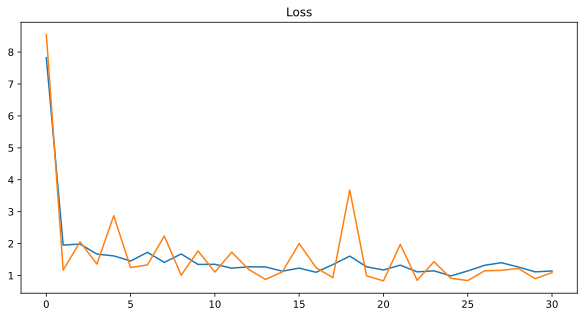

In [248]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [250]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [249]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn3[:,0])))*100:0.2f}%")

TEST mape: 11.76%


Добавление картинок не улучшило наш результат. Но подбор параметров аугментации, а также оптимального количества нейронов в слоях NN позволило улучшить результат baseline с 14.35% до 11.76%. Такж в ходе экпериментов был применен Fine-tuning, но он не показал улучшения результата, поэтому в конечной модели я его не использовала.

In [251]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv('nn3_submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,"643,078.75"
1,1096405886,"2,693,568.50"
2,1100195294,"859,694.44"
3,1099827282,"542,813.50"
4,1100076198,"3,063,971.75"


# Blend

In [255]:
blend_sub_predict = (submissions['blend'] + np.exp(sub_predict_nn3[:,0])) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,"629,579.40"
1,1096405886,"2,616,990.97"
2,1100195294,"762,134.11"
3,1099827282,"504,091.50"
4,1100076198,"2,916,611.38"


# Итоги и выводы

При работе над проектом была проведена большая комплексная работа. Были применены следующие навыки:

-Иследование, обработка и подготовка данных. Закреплены знания о библиотеках pandas, numpy, matplotlib, seaborn, scipy

-Построение ML моделей. Закреплены знания о библиотеках sklearn, CatBoost

-Построение нейронных сетей. Изучены и отработы методы и библиотеки для обработки текста (nltk, pymystem3, Tokenizer, sequence) и изображений (ImageDataAugmentor, albumentations).
был изучен новый инструмент - итератор tf.data.Dataset для передачи данных в метод .fit() модели keras.

Работа выпонялась на площадке Kaggle, которая предоставляет вычислительные мощности (CPU и GPU) для такого типа задач, что оказалось очень кстати при работе с текстом и изображениями. 

Из результатов работы можно сделать вывод, что данная задача хорошо решается с помощью машинного обучения и простых нейронных сетей. Добавление текста и изображений в данной задаче не привело к улучшению результата, но опыт построения multi-input нейросетей был получен.